# Time Series Forecasting Benchmark

---------

## Table of Contents

1. [Introduction](#Introduction)
2. [Datasets](#Datasets)
3. [Statistical Models](#ARIMA-and-SARIMA)
4. [Deep Neural Models](#Deep-Neural-Models)
   - [LSTM](#Long-Short-Term-Memory)
   - [Transformer](#Transformer)
5. [Continuous Neural Models](#Continuous-Neural-Models)
   - [LTCs](#Liquid-Time-Constant-Networks)
   - [CfCs](#Closed-Form-Continuous-Time-Networks)
6. [Conclusions](#Conclusions)

---------


## Introduction

In the realm of Artificial Intelligence (AI), a time series refers to a sequence of data points indexed in chronological order, typically recorded at equally spaced intervals. Common examples include ocean tide heights, sunspot counts, and daily stock market values, such as the Dow Jones Industrial Average. Time series data is often visualized using run charts, allowing for the identification of trends over time.

Time series analysis encompasses a range of techniques aimed at extracting meaningful statistics from temporal data, with applications across various fields including statistics, econometrics, weather forecasting, and even signal processing. A crucial aspect of this analysis is time series forecasting, where models predict future values based on historical observations, typically treating the data as a stochastic process.

Unlike cross-sectional studies, which analyze relationships without a time component, time series analysis focuses on the inherent temporal ordering of data points, recognizing that observations close in time are likely more correlated than those further apart. This characteristic distinguishes it from spatial data analysis, where observations relate to geographical locations rather than time.

In AI, time series analysis can be applied to various data types, including continuous real-valued data, discrete numeric data, and even symbolic sequences like text. By leveraging the unique properties of time series data, AI models can enhance predictive capabilities across diverse applications, from finance to natural language processing.

-----

## Benchmarking Various Models on X-modal Time Series Dataset

This notebook aims to evaluate and compare the performance of various modeling approaches against the univariate time series datasets. 
<br>
The models are categorized into three distinct groups:

1) Classical Models:
    - ARIMA (AutoRegressive Integrated Moving Average)
    - SARIMA (Seasonal AutoRegressive Integrated Moving Average)
   
<br>

2) Deep Neural Models:
    - LSTM (Long Short-Term Memory Networks)
    - Transformer (Encoder)

<br>

3) Continuous Deep Neural Models:
    - LTC (Linear Time-Constant Models)
    - CfC (Closed Form Continuous Models)

<br>

Through this comparative analysis, we seek to uncover insights regarding the strengths and weaknesses of each model type in capturing the 
complexities of the time series data.

------

# Utility Functions

In [1]:
import pandas as pd

In [2]:
# Utility function that fixes how the dataframe is indexed
def fix_index(df: pd.DataFrame, target_index_col: str, use_utc: bool) -> pd.DataFrame:
    target_df = df.copy()
    target_df[target_index_col] = pd.to_datetime(df[target_index_col], utc=use_utc)
    target_df.set_index(target_index_col, inplace=True)
    return target_df

--------

## Datasets

The benchmark can be executed on all three of the following datasets, however this instance of the notebook relies on the <b>AirPassengers</b> dataset.


1) <a href="https://www.kaggle.com/datasets/rakannimer/air-passengers" target="_blank">AirPassengers
2) <a href="https://www.kaggle.com/datasets/dhruvildave/google-trends-dataset" target="_blank">Google Trends
3) <a href="https://www.kaggle.com/datasets/jarredpriester/california-wine-production-19802020" target="_blank">California Wine Production

Other notable datasets can be found <a href="https://www.kaggle.com/discussions/general/458356" target="_balnk">here.

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
# Define a DataFrame that will contain all of the results of the performances of the various models
column_names = ["Model", "Train MSE", "Test MSE", "Training RMSE", "Test RMSE"]
results = list()

In [5]:
# I will be using a standard scaler to normalize the data in order to favor numerical stability with the neural models
# Arima and statistical models in general do not normally use standardized data
scaler = StandardScaler()

In [6]:
raw_df = pd.read_csv("./datasets/AirPassengers.csv")
raw_df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [7]:
# Fix the indexing of the raw dataframe for the statistical models
raw_df = fix_index(raw_df, "Month", False)
raw_df = raw_df.asfreq("MS")
raw_df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


------

## Model Summary

Classical models like ARIMA and SARIMA are grounded in statistical methods and are effective for univariate time series analysis, with SARIMA accommodating seasonal effects. <br>
Deep neural models (LSTM, CNN, Transformer) leverage neural network architectures to capture complex patterns in sequential data, while continuous deep neural models (Neural ODEs, LTC) provide frameworks for modeling continuous-time processes and dynamic systems. <br><br>
Each category offers unique strengths tailored to different types of time series forecasting tasks.

------

### Disclaimer
<i>
This study focuses on comparing the proposed models with a well-established task in the AI community. However, this comparison primarily highlights the methodological differences between the approaches, assessed through numerical performance metrics.</i> <br><br>

<i>For a more comprehensive evaluation of state-of-the-art time series forecasting models, refer to the official</i> [*Papers With Code page*](https://paperswithcode.com/task/time-series-forecasting).


--------

# ARIMA and SARIMA 

In this section we'll use what's known as the Box-Jenkins method of forecasting. The approach starts with the assumption that the process that generated the time series can be approximated using an ARMA model if it is stationary. <br><br>
This method consists of four steps:

1) Identification: Assess whether the time series is stationary, and if not, how many differences are required to make it stationary. Then, generate differenced data for use in diagnostic plots. Identify the parameters of an ARIMA model for the data from auto-correlation and partial auto-correlation.

2) Estimation: Use the data to train the parameters (that is, the coefficients) of the model.

3) Diagnostic Checking: Evaluate the fitted model in the context of the available data and check for areas where the model can be improved. In particular, this involves checking for overfitting and calculating the residual errors.

4) Forecasting: Now that you have a model, you can begin forecasting values with your model.

--------

In [8]:
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
#Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='#Passengers'>)

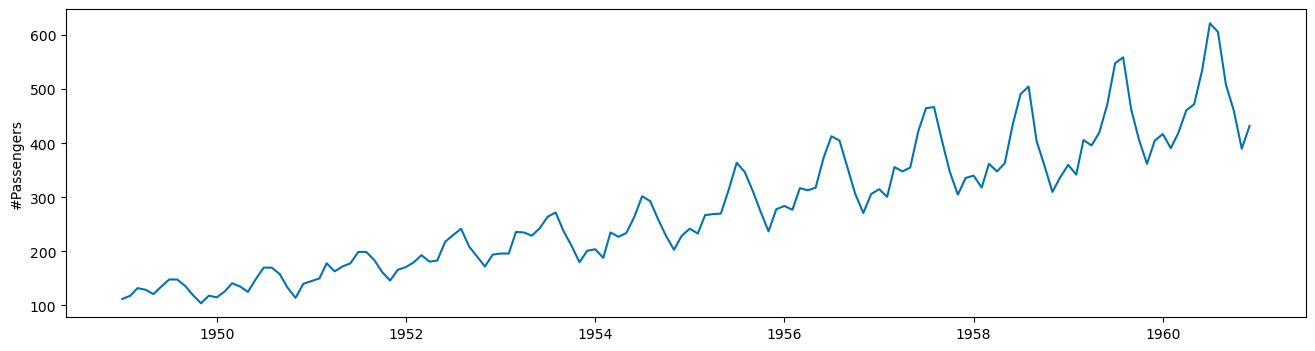

In [9]:
from sktime.utils.plotting import plot_series
plot_series(raw_df, markers=' ')

We can confirm that our time series is non-stationary by using two tests: the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. First, the ADF test. This is a type of statistical test called a unit root test. The ADF test is conducted with the following assumptions:

- The null hypothesis for the test is that the series is non-stationary, or series has a unit root.
- The alternative hypothesis for the test is that the series is stationary, or series has no unit root.

If the null hypothesis cannot be rejected, then this test may provide evidence that the series is non-stationary. This means that when you run the ADF test, if the test statistic is less than the critical value and p-value is less than 0.05, then we reject the null hypothesis, which means the time series is stationary.

In [10]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(raw_df)
print(adf_result[1])

0.9918802434376411


We can see that the data is not currently stationary because the ADF test value is above 0.05. Running the KPSS test can help confirm this.

In [11]:
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(raw_df)
print(kpss_result[1])

0.01


/tmp/ipykernel_601056/2986476509.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(raw_df)


Here the KPSS test also indicates that our time series is not stationary becauase the KPSS test result is below 0.05.

Having two tests which may or may not agree can be confusing. If KPSS and ADF agree that the series is stationary then we can consider it stationary and there’s no need to to use a difference term in the ARIMA model.

If the ADF test finds a unit root but KPSS finds that the series is stationary around a deterministic trend then the series is trend-stationary, and it needs to be detrended. You can either difference the time series by using the diff method or a Box-Cox transformation may remove the trend.

If the ADF does not find a unit root but KPSS claims that it is non-stationary then the series is difference stationary. We'll need to difference the data before passing data to our autoregressive model.

If KPSS and ADF agree that the series is non-stationary then we can consider it non-stationary. We'll need to difference the data before passing data to our autoregressive model.

We'll use the decompose method to determine what may need to be removed from the time series in order to fix it.

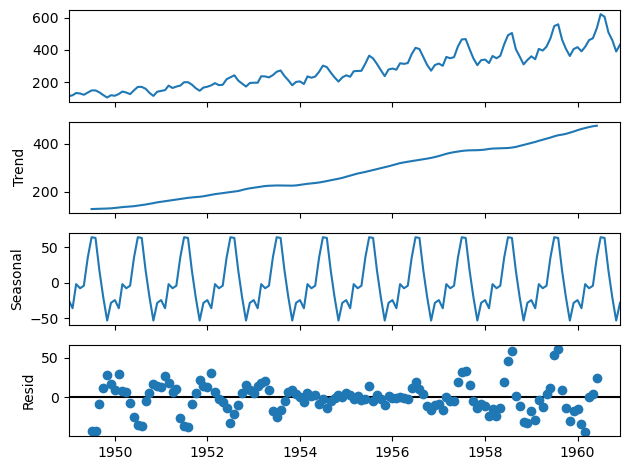

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt

result = seasonal_decompose(raw_df, model='additive')
result.plot()
plt.show()

The naive decomposition method is a simple one and there are more advanced decompositions available like Seasonal and Trend decomposition using Loess or STL decomposition. We don't want to make too many strong inferences from the results of this output. It does in this case though show us that there is a strong trend and seasonality present.

We can see that our time series contains trend and seasonal components but also that the variance of the time series is increasing over time. ARIMA models handle seasonality and non-stationarity well but they don't handle changes in variance or heteroskedasticity especially well.

When we encounter heteroskedasticity in a time series it's common to take a log transformation to manage it. One tool for doing this is the Box-Cox transformation.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='#Passengers'>)

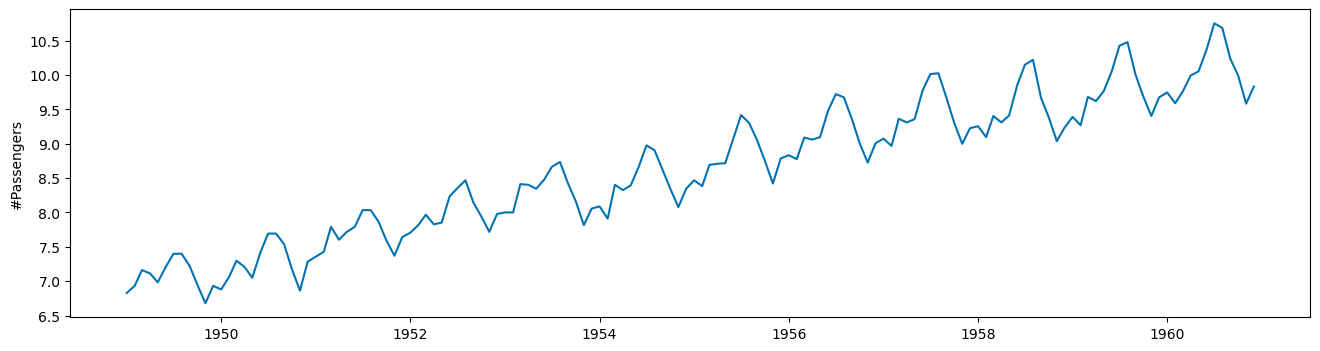

In [13]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

raw_df["#Passengers"],fitted_lambda = boxcox(raw_df["#Passengers"],lmbda=None)
plot_series(raw_df["#Passengers"], markers=' ')

Now the trend is still present, but the variance has decreased enough that we can investigate how ARIMA models will fit our data.

First, create a test train split that can be used both train our model and then test the efficacy of that model. We'll hold out the last 24 values of the data set as a testing set.

In [14]:
from sktime.split import temporal_train_test_split
ap_train, ap_test = temporal_train_test_split(raw_df, test_size=36)

Next, we need to check to see where our de-trended time series data contains autocorrelations. We can see the degree to which a time series is correlated with its past values by calculating the auto-correlation. Calculating the autocorrelation can answer questions about whether the data exhibit randomness and how related one observation is to an immediately adjacent observation. This can give us a sense of what sort of model might best represent the data. The autocorrelations are often plotted to see the correlation between the points up to and including the lag unit. There are two approaches to autocorrelations: the autocorrelation function (ACF) and the partial autocorrelation function (PACF).

In ACF, the correlation coefficient is in the x-axis whereas the number of lags (referred to as the lag order) is shown in the y-axis.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

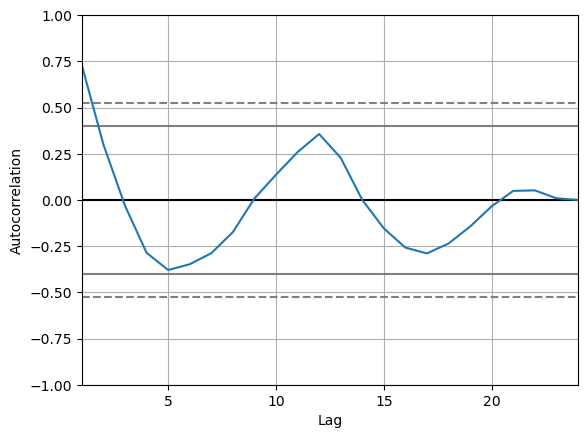

In [15]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ap_train[-24:])

Across 24 time units, the detrended series still shows a positive but decreasing correlation at lags 13 and 22 and a negative and decreasing correlation at lags 5, 17. This would indicate that our time series still has a seasonality component to it. There are no values outside of the critical zone 0.5 ; -0.5.

It is also a good idea to check the Partial Autocorrelation Function (PACF) as well. A partial correlation is a conditional correlation. As an example, think of a time series where the time series contains values for Y at Xt, Xt+1, and Xt+2. The partial correlation between Y and Xt+2 is the correlation between the variables determined taking into account how both Y and Xt+2 are related to Xt and Xt+1.

The PACF is helpful in determining the order of the AR part of the ARIMA model. It is also useful to determine or validate how many seasonal lags to include in the forecasting equation of a moving average based forecast model for a seasonal time series. This is called the seasonal moving average (SMA) order of the process.

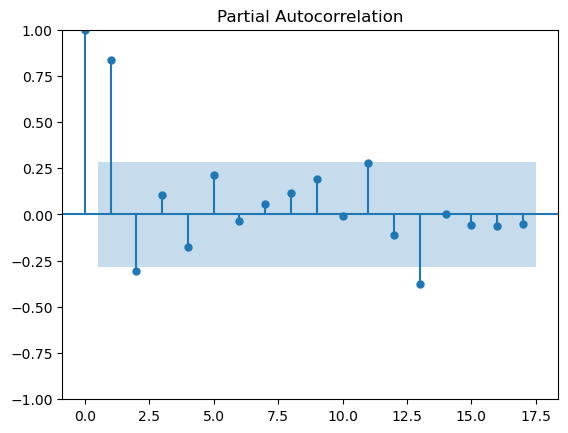

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ap_train[-48:])
plt.show()

Again, the values that is outside of the critical range of 0.5 to -0.5is 2 so this indicates a value for the autoregressive component of our ARIMA model.

A rough rubric for when to use Autoregressive terms in the model is when:

- ACF plots show autocorrelation decaying towards zero
- PACF plot cuts off quickly towards zero
- ACF of a stationary series shows positive at lag 1

A rough rubric for when to use moving average terms in the model is when:

- The ACF is negatively autocorrelated at lag 1
- ACF that drops sharply after a few lags
- PACF decreases gradually rather than suddenly

We can see from our two plots that our ACF plot shows a positive value at lag 1 and that the PACF cuts off somewhat quickly. This might indicate that we should use an AR term in our model.

Now that we have a sense of what kinds of ARIMA model might represent our data well, we can begin training a model.

First, we can call the arima function without a seasonal component, which has the following parameters

ARIMA(dataset, order)

The order is a tuple with 3 values:

- p: the order of the autoregressive term
- d: degree of differencing
- q: the number of moving average terms


Since we saw characteristics in the ACF and PACF plots that might indicate an AR model, we'll create a first-order autoregressive model. We use the checkresiduals function to generate graphs of the residuals, the ACF, and the distribution of the residuals. We'll use an autoregressive term and a first difference term because our data exhibits non-stationarity.

In [17]:
from statsmodels.tsa.arima.model import ARIMA

ap_model = ARIMA(ap_train, order=(2,1,0))
ap_model_fit = ap_model.fit()

In [18]:
print(ap_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  108
Model:                 ARIMA(2, 1, 0)   Log Likelihood                   8.376
Date:                Fri, 11 Oct 2024   AIC                            -10.752
Time:                        00:17:19   BIC                             -2.733
Sample:                    01-01-1949   HQIC                            -7.501
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2321      0.114      2.033      0.042       0.008       0.456
ar.L2         -0.1906      0.126     -1.512      0.131      -0.438       0.057
sigma2         0.0500      0.009      5.293      0.0

There is a lot to look at here. We can see the coefficients for the model specification and some of the calculated statistics for it:

- sigma2: this represents the variance of the residual values, lower is better
- log likelihood: this is maximum likelihood estimation for the ARIMA model, higher is better
- aic: a measure of the goodness of fit and the parsimony of the model, lower is better

Let’s plot the residuals to ensure there are no patterns in them. We're hoping for a constant mean and variance.

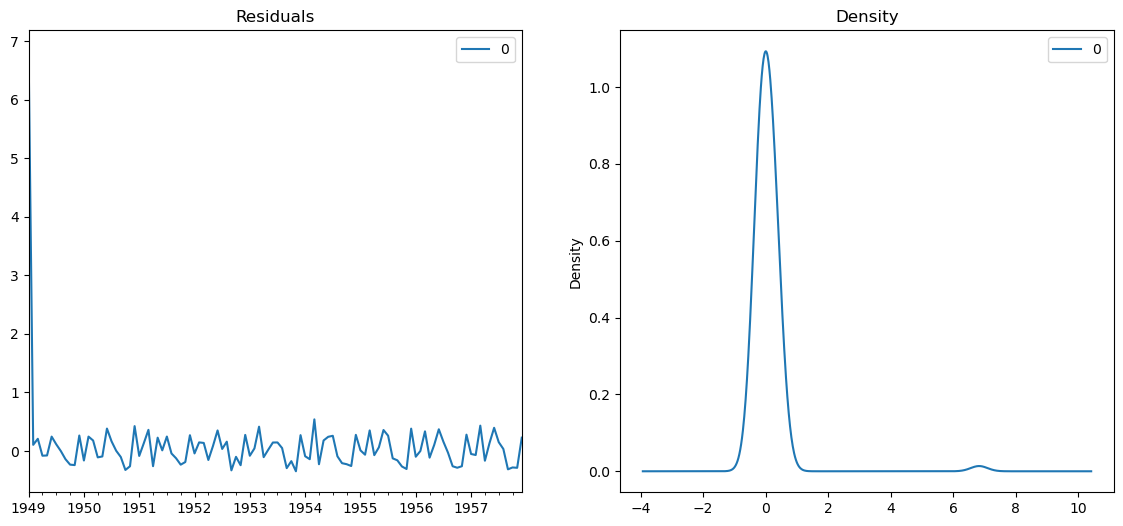

In [19]:
# density plot of residuals
ap_residuals = pd.DataFrame(ap_model_fit.resid)
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
ap_residuals.plot(title = "Residuals", ax = ax[0])
ap_residuals.plot(kind = 'kde', title = 'Density', ax = ax[1])
plt.show()

We can see that as the variance increases, so do the residuals but this may simply be a feature of our data. It's time to see how the predictive power of the fitted model matches the test data. The test data can be added one time point at a time to the train data to allow the model to include the new data point in the training.

In [20]:
ap_history = ap_train
ap_predictions = list()
# walk-forward validation
for t in range(len(ap_test),0,-1):
    ap_model = ARIMA(raw_df[:-t], order=(3,1,0));
    ap_model_fit = ap_model.fit();
    ap_output = ap_model_fit.forecast();
    yhat = ap_output.iloc[0]
    ap_predictions.append(yhat)

/home/drew/miniconda3/envs/data-analytics/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/tmp/ipykernel_601056/293756544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap_test.loc[:,'predictions'] = ap_predictions.copy()


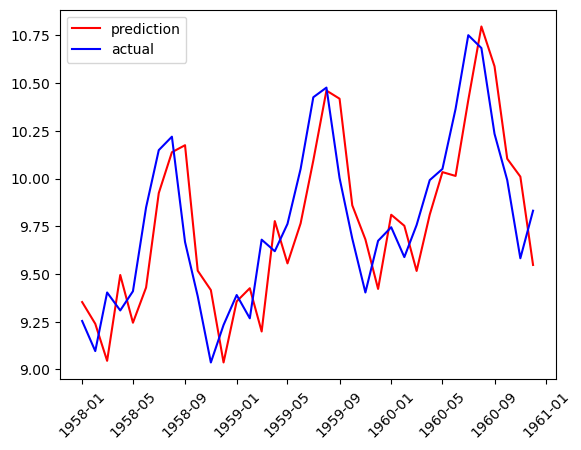

In [21]:
ap_test.loc[:,'predictions'] = ap_predictions.copy()

plt.plot(ap_test['predictions'], color='red', label='prediction')
plt.plot(ap_test["#Passengers"], color='blue', label='actual')
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate forecasts
mse = mean_squared_error(ap_test['predictions'], ap_test["#Passengers"])
rmse = sqrt(mse)

results.append(["ARIMA", -1, mse, -1, rmse])

print("Test MSE:\t{:.2f}".format(mse))
print("Test RMSE:\t{:.2f}".format(rmse))

Test MSE:	0.07
Test RMSE:	0.27


We can see a root mean squared error of 1.171. One feature of the original data set that our model isn't addressing is the seasonality. Another technique for creating ARIMA models is to use an Auto ARIMA implementation that creates a model for us.

Seasonal autoregressive integrated moving average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that supports time series data with a seasonal component. To do this, it adds three new hyperparameters to specify the autoregression, differencing and moving average for the seasonal component of the series, as well as an additional parameter for the period of the seasonality. A SARIMA model is typically expressed SARIMA((p,d,q),(P,D,Q)), where the lower case letters indicate the non-seasonal component of the time series and the upper case letters indicate the seasonal component

The pmdarima library provides access to an auto-ARIMA process which seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model. In order to find the best model, auto-ARIMA optimizes for a given information_criterion, one of Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag” (for validation scoring), respectively, and returns the ARIMA which minimizes the value.

To determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyperparameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In [23]:
import pmdarima as pm

ap_auto_model = pm.auto_arima(ap_train, start_p=1, start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      m=12, # frequency of series
                      d=None, # let model determine 'd'
                      seasonal=True, # Use Seasonality
                      information_criterion='aicc',
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

In [24]:
print(ap_auto_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  99.613
Date:                            Fri, 11 Oct 2024   AIC                           -193.226
Time:                                    00:17:24   BIC                           -185.564
Sample:                                01-01-1949   HQIC                          -190.130
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3515      0.096     -3.651      0.000      -0.540      -0.163
ma.S.L12      -0.5323      0.110   

We can see that the model is SARIMAX(2, 1, 1)x(2, 0, [1, 2], 12), which means that the non-seasonal components are 2, 1, 1, and the seasonal components are 2, 0, [1,2].

The AIC of the generated SARIMA model is less than half of the non-seasonal model we created previously. This could indicate that the seasonal component is an important feature for our modeling. The plot_diagnostics method can help us see residuals of the model, the histogram of errors, a Q-Q normality plot, and a correlation plot of the errors called a correlogram.

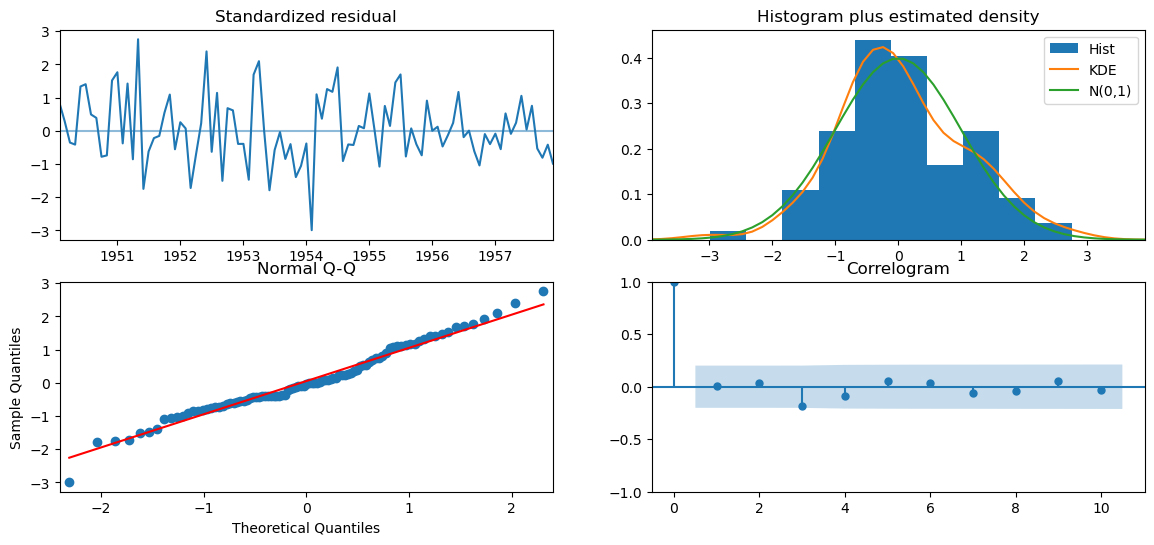

In [25]:
ap_auto_model.plot_diagnostics(figsize=(14, 6))
plt.show()

In [26]:
ap_history = ap_train
ap_auto_predictions = ap_auto_model.predict(len(ap_test))

/tmp/ipykernel_601056/480938341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap_test.loc[:, 'auto_predictions'] = ap_auto_predictions.copy()


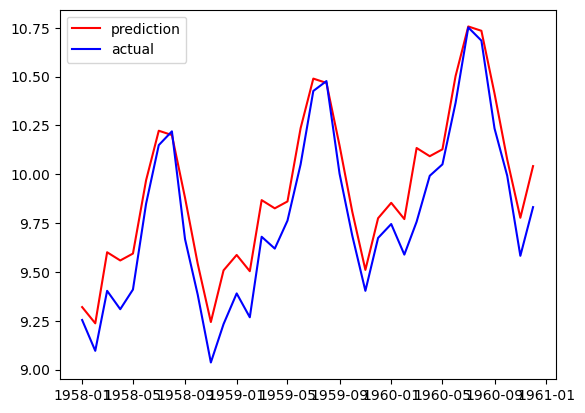

In [27]:
ap_test.loc[:, 'auto_predictions'] = ap_auto_predictions.copy()

plt.plot(ap_test['auto_predictions'], color='red', label='prediction')
plt.plot(ap_test['#Passengers'], color='blue', label='actual')
plt.legend(loc="upper left")
plt.show()

In [28]:
# evaluate forecasts
s_ap_mse = mean_squared_error(ap_test['auto_predictions'], ap_test['#Passengers'])
s_ap_rmse = sqrt(s_ap_mse)

results.append(["SARIMA", -1, s_ap_mse, -1, s_ap_rmse])

print("Test MSE:\t{:.2f}".format(s_ap_mse))
print("Test RMSE:\t{:.2f}".format(s_ap_rmse))

Test MSE:	0.03
Test RMSE:	0.17


-------

# Deep Neural Models

Unlike statistical models like ARIMA and SARIMA, which prioritize explainability and interpretability, Deep Learning models focus on making accurate predictions using a different strategy. Statistical methods emphasize understanding the relationships between variables and testing hypotheses, often using techniques like Ordinary Least Squares (OLS) for model fitting. These models allow for clear interpretation of coefficients and underlying patterns in the data.

On the other hand, Deep Learning models (akin to predictive models) prioritize accurate prediction over interpretability. They use algorithms like Gradient Descent to minimize errors and adjust model weights based on input variables.

For example, a Linear Regressor can be interpreted and used differently depending on the context:

- In Statistical Analysis, the focus is on hypothesis testing and explaining the relationship between variables using OLS.
- In Predictive Analytics, the goal is to optimize predictions, often using Gradient Descent, without needing to explain the underlying mechanisms as clearly.

This distinction reflects the broader difference between statistical models and machine learning approaches, where explainability in the former contrasts with prediction accuracy in the latter.

-------

## Long Short Term Memory

Long Short-Term Memory (LSTM) networks are a specialized type of Recurrent Neural Network (RNN) designed to learn from sequential data while effectively managing the issue of long-range dependencies. LSTMs are particularly well-suited for tasks where context from previous time steps influences the current prediction, such as in time series forecasting.

-------

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from scipy import stats
from typing import Tuple
import time
import resource

2024-10-11 00:17:25.499724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 00:17:25.511640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 00:17:25.514952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 00:17:25.523541: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 00:17:26.236154: W tensorflow/compiler/tf2

In [30]:
# The data for the Deep Learning models does not need to be as processed as that for the Statistical Models
d_df = pd.read_csv("./datasets/AirPassengers.csv", index_col = "Month")
d_df["Standardized Data"] = scaler.fit_transform(d_df[["#Passengers"]])
df = d_df[["Standardized Data"]]
df

,Standardized Data
Month,
1949-01,-1.407779
1949-02,-1.357590
1949-03,-1.240483
1949-04,-1.265578
1949-05,-1.332496
...,...
1960-08,2.724417
1960-09,1.904669
1960-10,1.511525


In [31]:
# Split into training and test sets
train_percentage = 0.70
validation_percentage = 0.10
n_samples = df.shape[0]

n_train = int(train_percentage * n_samples)
n_val = int(validation_percentage * n_samples)

In [32]:
train = df[:n_train]
validation = df[n_train: n_train + n_val]
test = df[n_train + n_val:]

In [33]:
# Generate windowed data
from typing import Tuple

"""
    Generates window - value pairs (overlapping)

    Args:
        sequence (pd.DataFrame): Input dataframe
        n_steps (int): number of timesteps (size of window)
        
    Returns:
        Tuple[Numpy ndarray, Numpy ndarray]
        
"""
def create_window(sequence: pd.DataFrame, n_steps: int) -> Tuple[np.array, np.array]:
    X, y = list(), list()
    np_sequence = sequence.to_numpy()
    for i in range(len(sequence) - n_steps - 1):
        X.append(np_sequence[i : i + n_steps])
        y.append(np_sequence[i + n_steps])
    return np.array(X), np.array(y)

In [34]:
n_features = 1
n_steps = 3

In [35]:
X_train, y_train = create_window(train, n_steps)
X_val, y_val = create_window(validation, n_steps)
X_test, y_test = create_window(test, n_steps)

In [36]:
y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()

In [37]:
# Define the LSTM Model's Architecture using the Sequential API
model = Sequential()
model.add(InputLayer((n_steps, n_features)))
model.add(LSTM(64))
model.add(Dense(8, "relu"))
model.add(Dense(1, "linear"))

I0000 00:00:1728598646.874365  601056 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-11 00:17:26.894697: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [40]:
# This custom callback will ensure that only the best model will be saved
c_point = ModelCheckpoint("models/ts_lstm.keras", save_best_only = True)

In [41]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Compile the model with an Optimizer and Loss Metric
model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.008), metrics = [RootMeanSquaredError()])

In [42]:
# Fit the model on the training data and benchmark its hardware resource consumption
start_time = time.time()
usage_start = resource.getrusage(resource.RUSAGE_SELF)

history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 500, verbose = 0, callbacks = [c_point])

end_time = time.time()
usage_end = resource.getrusage(resource.RUSAGE_SELF)

# Calculate elapsed time
elapsed_time = end_time - start_time

# Calculate CPU time
user_cpu_time = usage_end.ru_utime - usage_start.ru_utime
system_cpu_time = usage_end.ru_stime - usage_start.ru_stime

In [43]:
print(f"Elapsed Time: {elapsed_time:.4f} seconds")
print(f"User CPU Time: {user_cpu_time:.4f} seconds")
print(f"System CPU Time: {system_cpu_time:.4f} seconds")

Elapsed Time: 16.6535 seconds
User CPU Time: 20.2561 seconds
System CPU Time: 1.5558 seconds


In [44]:
train_mse = history.history["loss"][-1]
print("Training Set MSE:\t{:.3f}".format(history.history["loss"][-1]))

Training Set MSE:	0.018


In [45]:
# Load the model
from tensorflow.keras.models import load_model

model1 = load_model("models/ts_lstm.keras")

In [46]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data = { "Training Set Predictions" : train_predictions, "Baseline Values" : y_train })

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [47]:
train_results

,Training Set Predictions,Baseline Values
0,-1.202134,-1.265578
1,-1.236768,-1.332496
2,-1.284958,-1.215389
3,-1.160622,-1.106647
4,-1.076355,-1.106647
...,...,...
91,0.088781,-0.077781
92,0.026956,0.214986
93,0.453818,0.290269
94,0.327911,0.173162


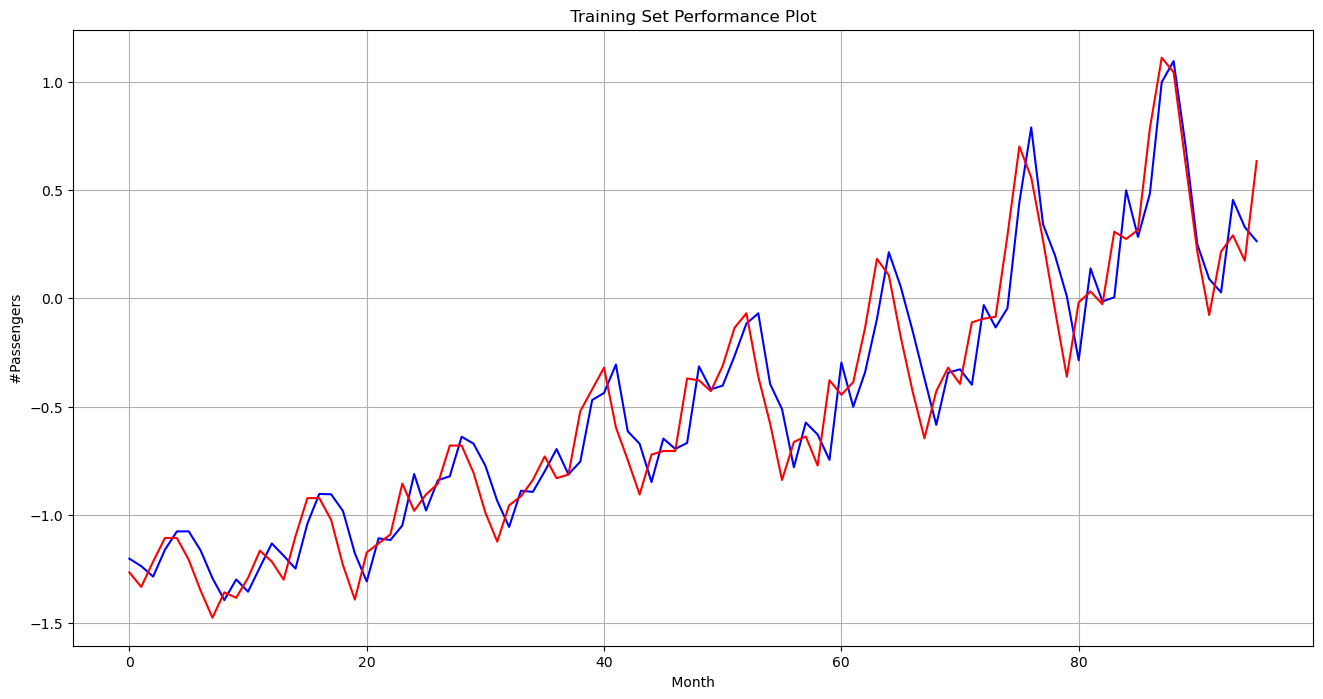

In [48]:
plt.figure(figsize=(16,8))
plt.title(" Training Set Performance Plot ")
plt.xlabel(" Month ")
plt.ylabel(" #Passengers ")
plt.grid()
plt.plot(train_results["Training Set Predictions"], color='b')
plt.plot(train_results["Baseline Values"], color='r')
plt.show()

In [49]:
# Test Evaluation
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data = { "Test Set Predictions" : test_predictions, "Baseline Values" : y_test })

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


In [50]:
X_test_vals = test_results["Test Set Predictions"].values
X_test_baselines = test_results["Baseline Values"].values

In [51]:
test_mse = mean_squared_error(X_test_vals, X_test_baselines)
test_rmse = sqrt(mean_squared_error(X_test_vals, X_test_baselines))

results.append(["LSTM", -1, test_mse, -1, test_rmse])

print("Test Set MSE:\t{:.3f}".format(test_mse))
print("Test Set RMSE:\t{:.3f}".format(test_rmse))

Test Set MSE:	0.166
Test Set RMSE:	0.407


/tmp/ipykernel_601056/1725765867.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


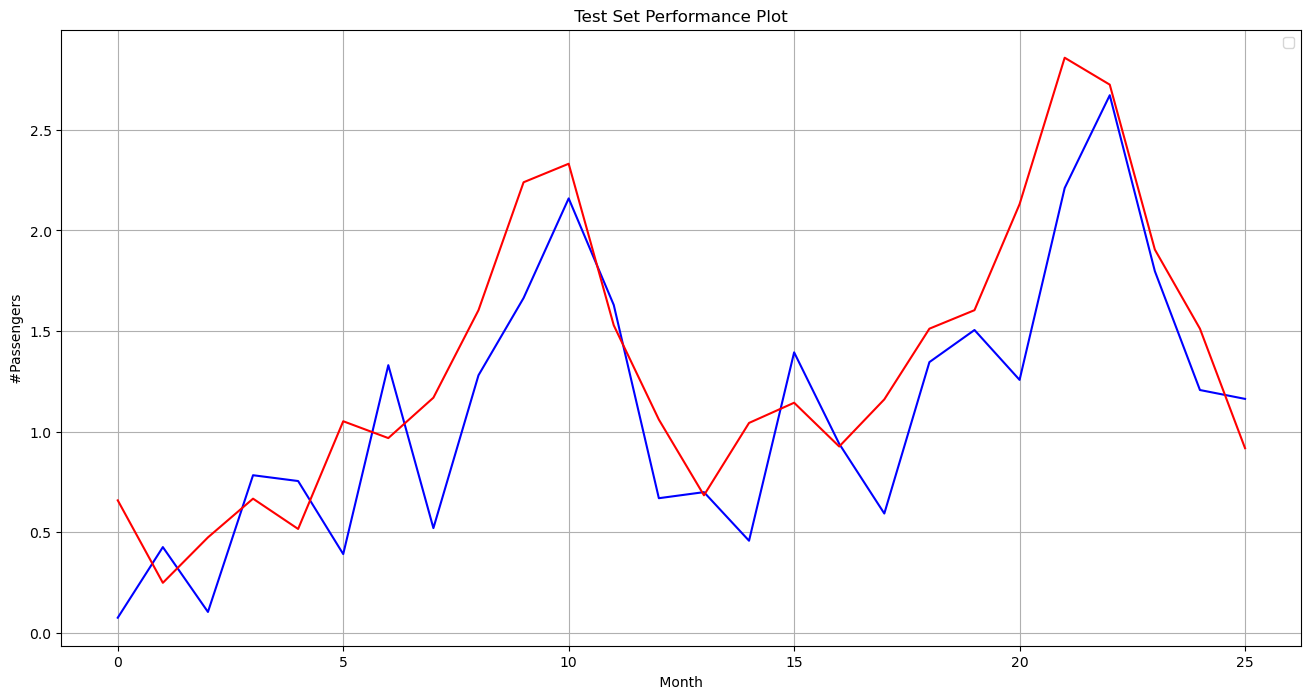

In [52]:
plt.figure(figsize=(16,8))
plt.title(" Test Set Performance Plot ")
plt.xlabel(" Month ")
plt.ylabel(" #Passengers ")
plt.grid()
plt.plot(test_results["Test Set Predictions"], color='b')
plt.plot(test_results["Baseline Values"], color='r')
plt.legend()
plt.show()

### Visualizing the performance evaluation

In [53]:
# Plot the training and validation losses
train_loss = history.history['loss']
val_loss = history.history['val_loss']

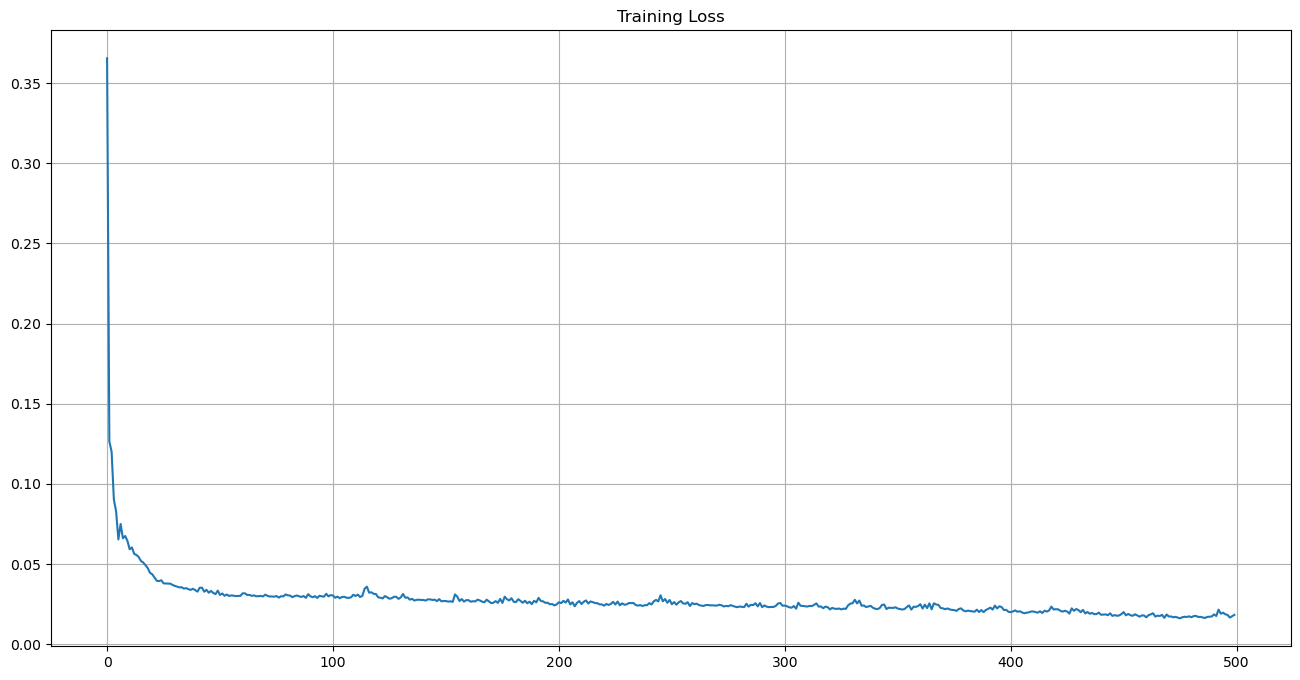

In [54]:
plt.figure(figsize=(16,8))
plt.title("Training Loss")
plt.plot(train_loss)
plt.grid()
plt.show()

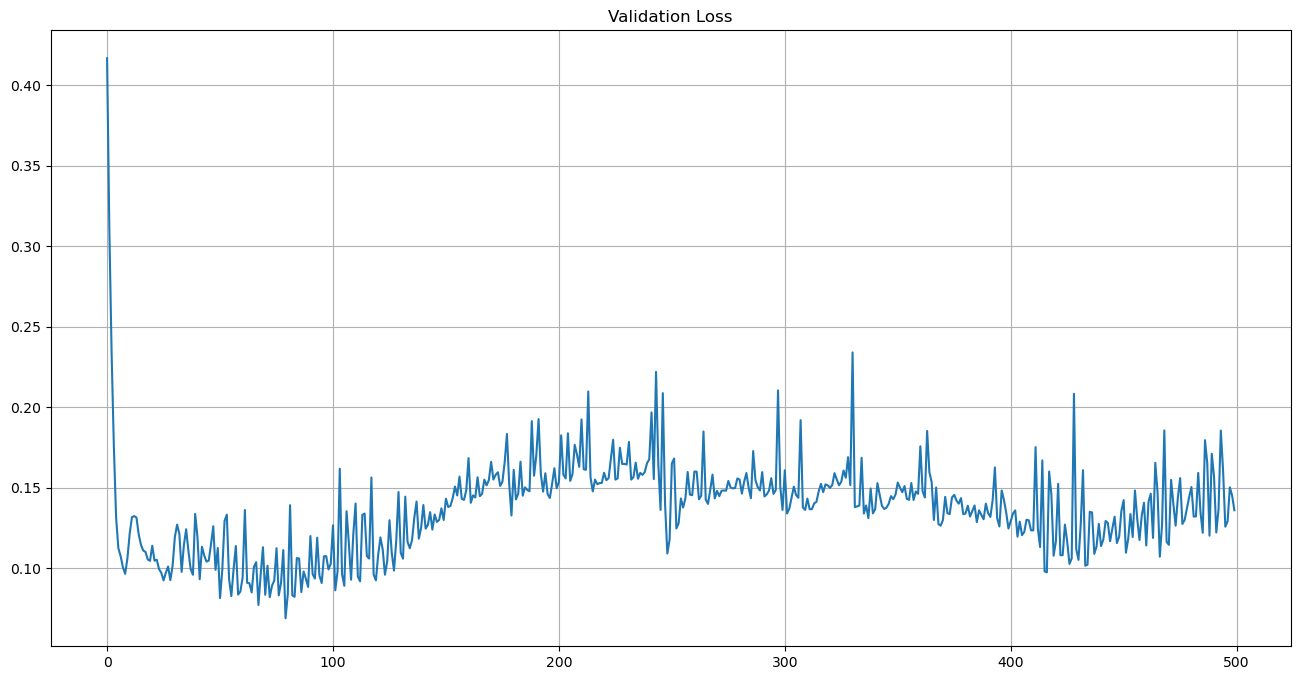

In [55]:
plt.figure(figsize=(16,8))
plt.title("Validation Loss")
plt.plot(val_loss)
plt.grid()
plt.show()

In [56]:
# Summary of the LSTM's Performance
print("Train MSE:\t{:.3f}\t\t|\tTest MSE:\t{:.3f}\t|\tTest RMSE:\t{:.3f}".format(train_mse, test_mse, test_rmse))

Train MSE:	0.018		|	Test MSE:	0.166	|	Test RMSE:	0.407


--------

## Average Model performance

Considering that most models have their weights initialized pseudo-randomly, to favor symmetry breaking, and each hardware architecture
has its own mid-low level specific implementations which could potentially affect the accuracy of the results, I will
run the training on the same data for 30 times (number not chosen at random but due to the law of large numbers) and from the obtained data, confidence intervals shall be computed.

<br>

Ideally the std dev should be small and thus the performances should be quite comparable regardless on the used hardware

--------

In [57]:
# Keeping a history of traind models' performances in order to compute the confidence intervals of the estimates
def validation_loop(verbose : bool) -> list:
    model_val_performances = list()
    # The number of the range has been chosen for a reason!
    for i in range(30):
        if verbose:
            print(" -- Validation Loop Iteration:\t{}\t|\t".format(i), end = "")
        iter_history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 500, verbose = 0, callbacks = [c_point])
        iter_val_loss = iter_history.history["val_loss"][-1]
        print("val_loss:\t{:.2f}".format(iter_val_loss))
        model_val_performances.append(iter_val_loss)
    return np.array(model_val_performances)

In [58]:
val_performances = validation_loop(True)

 -- Validation Loop Iteration:	0	|	val_loss:	0.19
 -- Validation Loop Iteration:	1	|	val_loss:	0.17
 -- Validation Loop Iteration:	2	|	val_loss:	0.16
 -- Validation Loop Iteration:	3	|	val_loss:	0.16
 -- Validation Loop Iteration:	4	|	val_loss:	0.15
 -- Validation Loop Iteration:	5	|	val_loss:	0.17
 -- Validation Loop Iteration:	6	|	val_loss:	0.16
 -- Validation Loop Iteration:	7	|	val_loss:	0.16
 -- Validation Loop Iteration:	8	|	val_loss:	0.16
 -- Validation Loop Iteration:	9	|	val_loss:	0.17
 -- Validation Loop Iteration:	10	|	val_loss:	0.15
 -- Validation Loop Iteration:	11	|	val_loss:	0.16
 -- Validation Loop Iteration:	12	|	val_loss:	0.19
 -- Validation Loop Iteration:	13	|	val_loss:	0.18
 -- Validation Loop Iteration:	14	|	val_loss:	0.18
 -- Validation Loop Iteration:	15	|	val_loss:	0.17
 -- Validation Loop Iteration:	16	|	val_loss:	0.18
 -- Validation Loop Iteration:	17	|	val_loss:	0.18
 -- Validation Loop Iteration:	18	|	val_loss:	0.17
 -- Validation Loop Iteration:	19	|	val_l

In [59]:
# Utility function to compute some statistics on the collected data (Validation and Test)
def compute_statistics(arr : np.array):
    print(" ------ Statistics ------ ")
    print(" Mean:\t{:.2f}".format(arr.mean()))
    print(" Std:\t{:.2f}".format(arr.std()))

In [60]:
# Utility function to compute the confidence interval of the given collected data
def compute_confidence_interval(arr : np.array, confidence = 0.95) -> Tuple[float, float]:
    # Calculate mean and standard deviation
    mean = arr.mean()
    std_dev = arr.std(ddof=1)  # Use ddof=1 for sample standard deviation
    n = len(arr)               # Sample size

    # Determine the t-score for the desired confidence level
    t_score = stats.t.ppf((1 + confidence) / 2, n - 1)

    # Calculate the margin of error
    margin_of_error = t_score * (std_dev / np.sqrt(n))

    # Calculate confidence interval
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)

    return confidence_interval

In [61]:
compute_statistics(val_performances)

 ------ Statistics ------ 
 Mean:	0.17
 Std:	0.01


In [62]:
confidence_interval = compute_confidence_interval(val_performances)
print("Confidence Interval:\t[{:.2f}, {:.2f}]".format(confidence_interval[0], confidence_interval[1]))

Confidence Interval:	[0.16, 0.17]


-------

As shown by the previously run test, the standard deviation is rather small on the machine I ran the experiments on, therefore it is safe to assume that the results I obtained will not diverge much from those that other might obtain on their machines should they choose to run the notebook on their hardware

---------

# Transformer

Transformers are a type of deep learning architecture that has revolutionized the field of natural language processing (NLP) since their introduction in the paper "Attention is All You Need" by Vaswani et al. in 2017. Unlike traditional recurrent neural networks (RNNs) and long short-term memory (LSTM) networks, which process data sequentially, transformers utilize a self-attention mechanism that allows them to weigh the importance of different input elements irrespective of their position in the sequence. This feature enables transformers to capture long-range dependencies in the data more effectively.

<br>

The transformer architecture, introduced in the paper "Attention is All You Need", consists of two main components: the encoder and the decoder. However, for many time series forecasting tasks, especially those focusing on historical data to make future predictions, only the encoder part is often utilized. Here’s a detailed look at the encoder architecture and how it applies to time series forecasting.

In [63]:
from typing import Tuple

import keras
from sklearn.metrics import root_mean_squared_error
from keras.layers import Input, Dense, Conv1D, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D

In [64]:
# Defining the Encoder component (stackable) of the Transformer architecture from the 'Attention is all you need' paper
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout = 0):
    # Normalization + Attention Layers
    x = LayerNormalization(epsilon = 1e-6)(inputs)
    x = MultiHeadAttention(key_dim = head_size, num_heads = num_heads, dropout = dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Layer
    x = LayerNormalization(epsilon = 1e-6)(res)
    x = Conv1D(filters = ff_dim, kernel_size = 1, activation = "relu")(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters = inputs.shape[-1], kernel_size = 1)(x)
    return x + res

In [65]:
# To make sure that the model is parametric enough, the following function is meant to aid in the building of the model
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout = 0,
    mlp_dropout = 0
):
    inputs = Input(shape = input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format = "channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation = "relu")(x)
        x = Dropout(dropout)(x)
    outputs = Dense(1)(x)
    return keras.Model(inputs, outputs)

In [66]:
# Configure the model
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size = 256,
    num_heads = 4,
    ff_dim = 4,
    num_transformer_blocks = 4,
    mlp_units = [128],
    mlp_dropout = 0.4,
    dropout = 0.25
)

In [67]:
model.compile(
    loss = MeanSquaredError(),
    optimizer = Adam(learning_rate = 0.001),
    metrics = [RootMeanSquaredError()]
)

In [68]:
best_model_callback = ModelCheckpoint("models/ts_transformer.keras", save_best_only = True)

In [69]:
fit_history = model.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    epochs = 500,
    batch_size = 64,
    callbacks = best_model_callback,
    verbose = 0
)

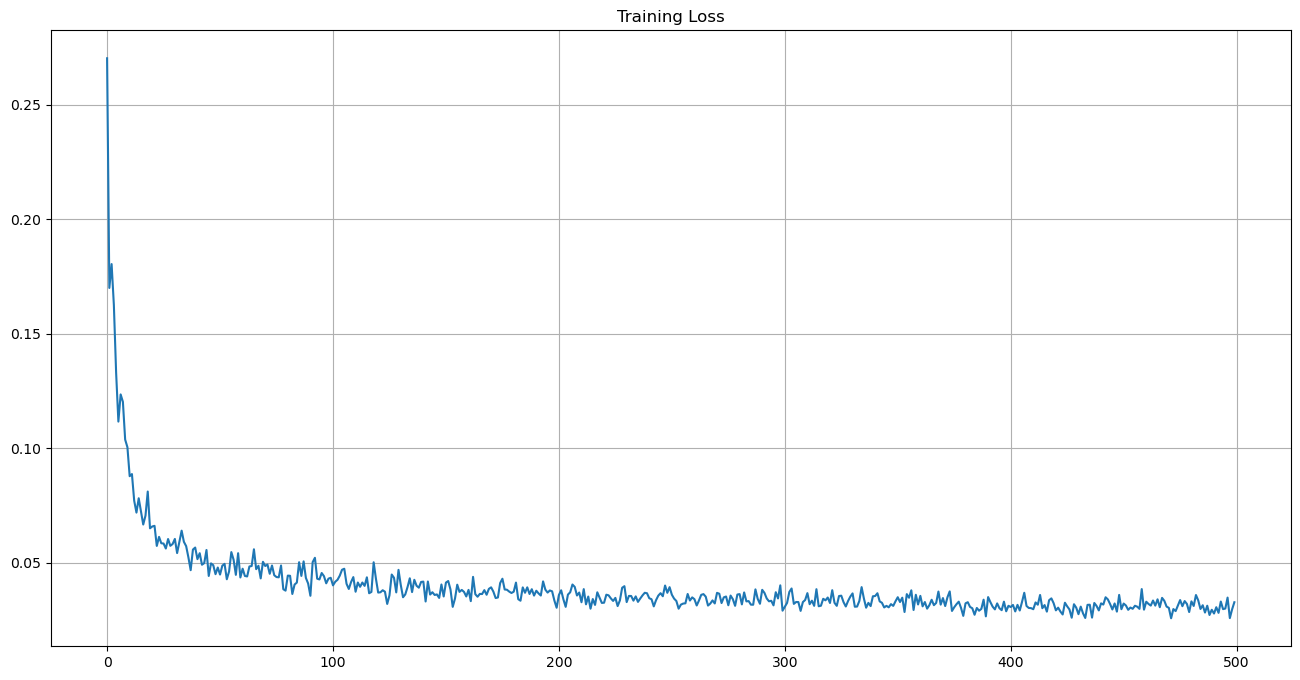

In [70]:
# Plot the Training Loss
plt.figure(figsize=(16,8))
plt.title("Training Loss")
plt.plot(fit_history.history["loss"])
plt.grid()
plt.show()

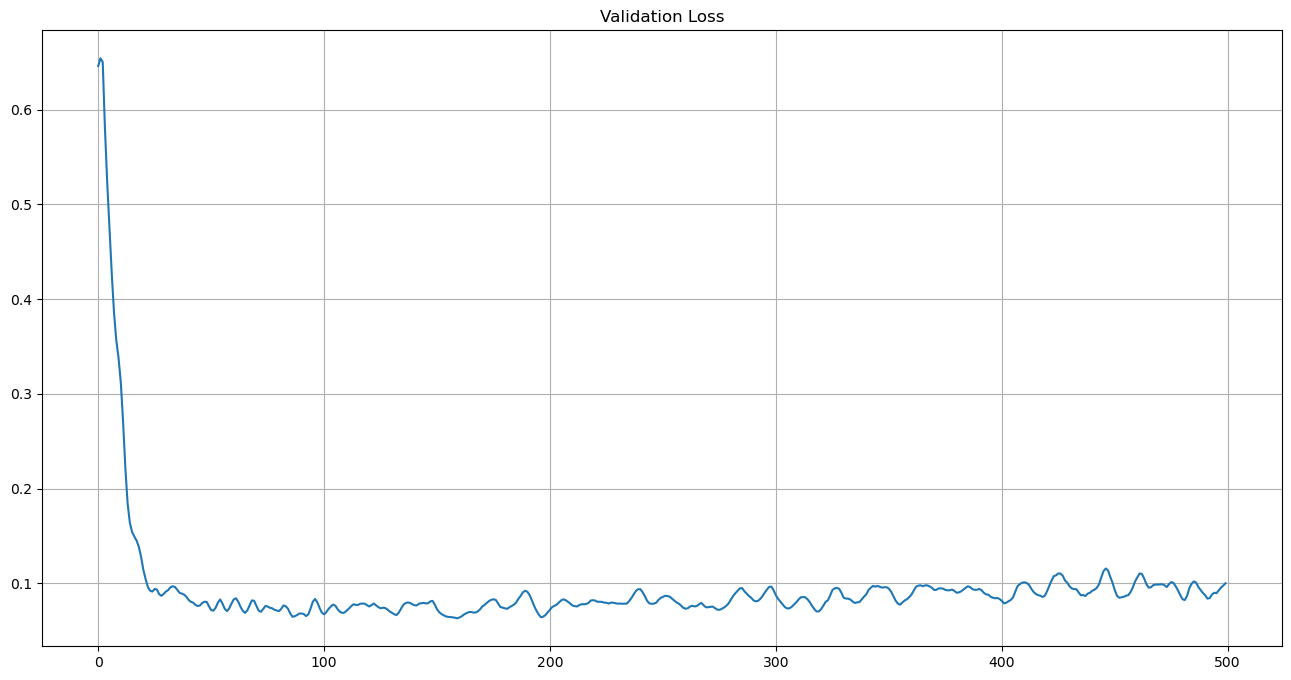

In [71]:
# Plot the validation history
plt.figure(figsize=(16, 8))
plt.title("Validation Loss")
plt.plot(fit_history.history["val_loss"])
plt.grid()
plt.show()

In [72]:
test_loss, test_accuracy = model.evaluate(
    X_test,
    y_test,
    verbose = 0
)

In [73]:
print("Traing MSE:\t{:.3f}\t|\tTest Loss:\t{:.3f}\t|\tTest Accuracy:\t{:.3f}".format(fit_history.history["loss"][-1], test_loss, test_accuracy))

Traing MSE:	0.033	|	Test Loss:	0.438	|	Test Accuracy:	0.661


In [74]:
train_preds = model.predict(X_train, verbose = 0)
test_preds = model.predict(X_test, verbose = 0)

In [75]:
train_mse = mean_squared_error(train_preds, y_train)
test_mse = mean_squared_error(test_preds, y_test)

train_rmse = sqrt(train_mse)
test_rmse = sqrt(test_mse)

In [76]:
transformer_rmse = root_mean_squared_error(test_preds.flatten(), y_test.flatten())

In [77]:
print("Train MSE:\t{:.3f}\t\t|\tTest MSE:\t{:.3f}".format(train_mse, test_mse))

Train MSE:	0.026		|	Test MSE:	0.438


In [78]:
print("Transformer Model's Evaluation Score (RMSE):\t{:.3f}".format(transformer_rmse))

Transformer Model's Evaluation Score (RMSE):	0.661


In [79]:
results.append(["Transformer", train_mse, test_mse, train_rmse, test_rmse])

----------

# Continuous Neural Models

Continuous Deep Learning Models are a class of machine learning frameworks designed to enable continuous training and deployment of models in dynamic environments. These models can learn from streaming data and adapt to new patterns and trends without requiring complete retraining from scratch. They are particularly useful in applications where data is continuously generated or updated, such as in time series analysis, real-time analytics, and online recommendation systems.

----------

## Liquid Time Constant Networks

Liquid Time Constant Networks (LTCNs) are a type of recurrent neural network architecture designed to effectively model temporal dynamics in data by incorporating liquid time constants that govern the responsiveness of neurons over time. Unlike traditional recurrent neural networks (RNNs), LTCNs can learn variable time dynamics and adapt their behavior based on the temporal structure of the input data.

--------

In [80]:
from ncps.wirings import AutoNCP
from ncps.keras import LTC
import seaborn as sns

In [81]:
# Define a custom wiring on the LTC Model

# 8 Neurons in total, 1 of which is the output neuron
wiring = AutoNCP(10, 1)

model = Sequential()
model.add(InputLayer(input_shape = (None, n_features)))
model.add(LTC(wiring))

model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.01), metrics = [RootMeanSquaredError()])

/home/drew/miniconda3/envs/data-analytics/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [82]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ltc (LTC)                       │ (None, 1)              │           474 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 474 (1.85 KB)

 Trainable params: 474 (1.85 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
checkpoint_callback = ModelCheckpoint("models/ts_ltc.keras", save_best_only = True)

-----

## Liquid Network's Model Wiring

The LTC Network can be used in several ways, one of which is with a specific [wiring](https://ncps.readthedocs.io/en/latest/api/wirings.html) adopted by the research made on [neural circuit policies](https://publik.tuwien.ac.at/files/publik_292280.pdf).

<br>

The wiring and specific Neural Architecture derives from research performed by [Dr. M. Lechner](https://scholar.google.com/citations?user=fIupeSAAAAAJ&hl=en) on the tap withdrawl, a biological instinct derived from the nervous system of the [C. Elegans](https://en.wikipedia.org/wiki/Caenorhabditis_elegans) nematode.

<br>

The neurons are divided into:

1) Input neurons (similar to those of a normal input layer)
2) Inter neurons (one type of hidden layer neuron)
3) Command neurons (which model the response of the previous nodes)
4) Motor neurons (the output layer)


<br>

For more detailed references on the API, visit the [official documentation](https://ncps.readthedocs.io/en/latest/)

------

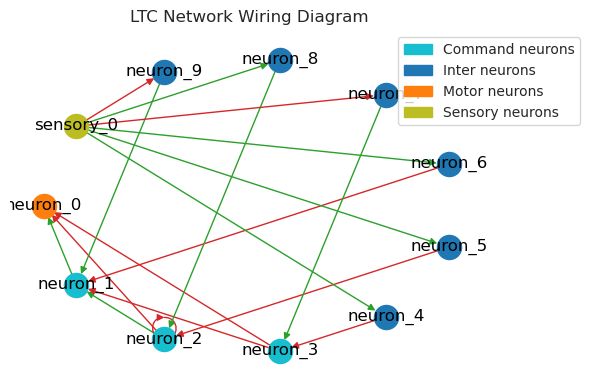

In [84]:
# Model's wirings
sns.set_style("white")
plt.figure(figsize=(6, 4))
plt.title("LTC Network Wiring Diagram")
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [85]:
# Fit on the training data
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 1000, callbacks = [checkpoint_callback], verbose = 0)

In [86]:
train_mse = history.history["loss"][-1]
print("Training MSE:\t{:.3f}".format(train_mse))

Training MSE:	0.032


In [87]:
train_preds = model.predict(X_train, verbose = 0)

In [88]:
train_predictions = pd.DataFrame(
    {
        "Train Predictions" : train_preds.flatten(),
        "Ground Trouth" : y_train.flatten()
    }
)
train_predictions

,Train Predictions,Ground Trouth
0,-1.195098,-1.265578
1,-1.213519,-1.332496
2,-1.255392,-1.215389
3,-1.174978,-1.106647
4,-1.069192,-1.106647
...,...,...
91,-0.109575,-0.077781
92,-0.033985,0.214986
93,0.297802,0.290269
94,0.385662,0.173162


[]

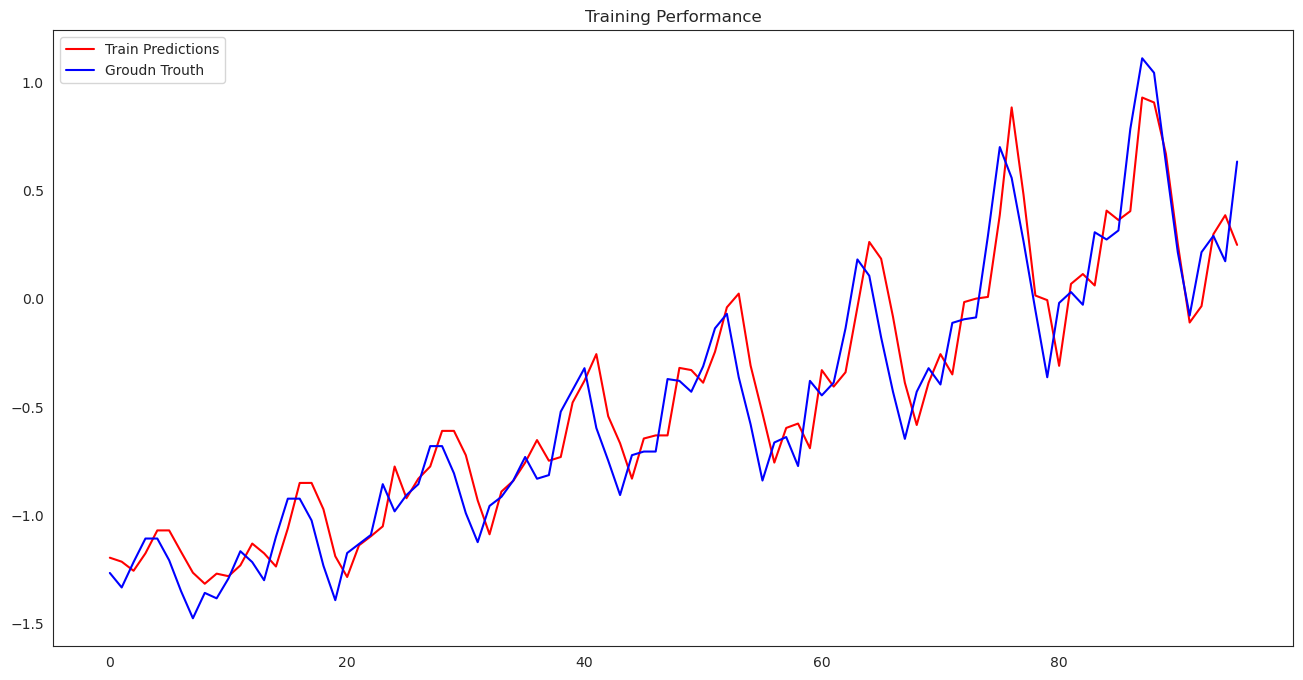

In [89]:
# Plot the Training performances
plt.figure(figsize=(16, 8))
plt.title("Training Performance")
plt.plot(train_predictions["Train Predictions"], color='r', label = "Train Predictions")
plt.plot(train_predictions["Ground Trouth"], color='b', label = "Groudn Trouth")
plt.legend()
plt.plot()

In [90]:
# Evaluate the model's Test Set Performances
test_preds = model.predict(X_test, verbose = 0)

In [91]:
test_predictions = pd.DataFrame(
    {
        "Test Predictions" : test_preds.flatten(),
        "Ground Trouth" : y_test.flatten()
    }
)
test_predictions

,Test Predictions,Ground Trouth
0,0.654594,0.658319
1,0.293351,0.248445
2,-0.095618,0.474294
3,0.448185,0.666684
4,0.738203,0.516118
5,0.298524,1.051463
6,0.764937,0.967815
7,0.673562,1.168570
8,0.732826,1.603538
9,0.861508,2.239260


In [92]:
mse = MeanSquaredError()
test_mse = mse(test_preds, y_test).numpy()
print("Test MSE:\t{:.3f}".format(test_mse))

Test MSE:	0.718


[]

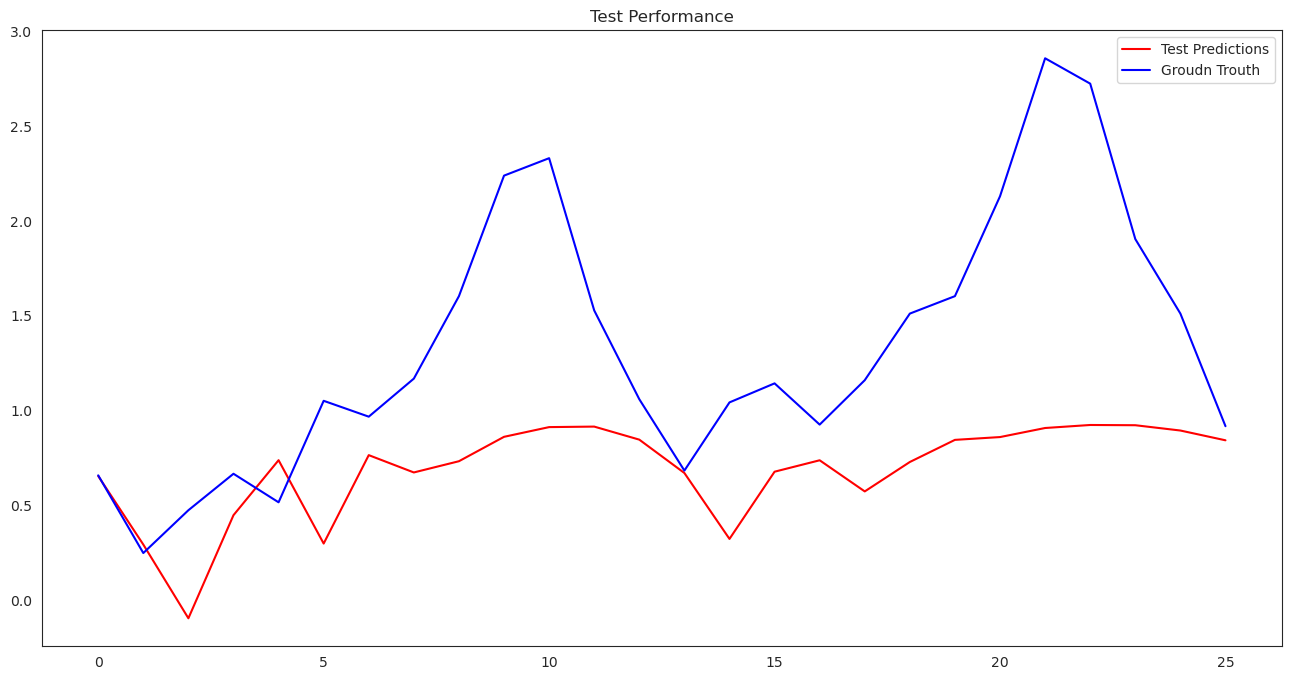

In [93]:
# Plot the test set's performances
plt.figure(figsize=(16, 8))
plt.title("Test Performance")
plt.plot(test_predictions["Test Predictions"], color='r', label = "Test Predictions")
plt.plot(test_predictions["Ground Trouth"], color='b', label = "Groudn Trouth")
plt.legend()
plt.plot()

In [94]:
print("Model Train MSE:\t{:.3f}\t\t|\tModel Test MSE:\t{:.3f}".format(train_mse, test_mse))

Model Train MSE:	0.032		|	Model Test MSE:	0.718


In [95]:
results.append(["LTC", train_mse, test_mse, sqrt(train_mse), sqrt(test_mse)])

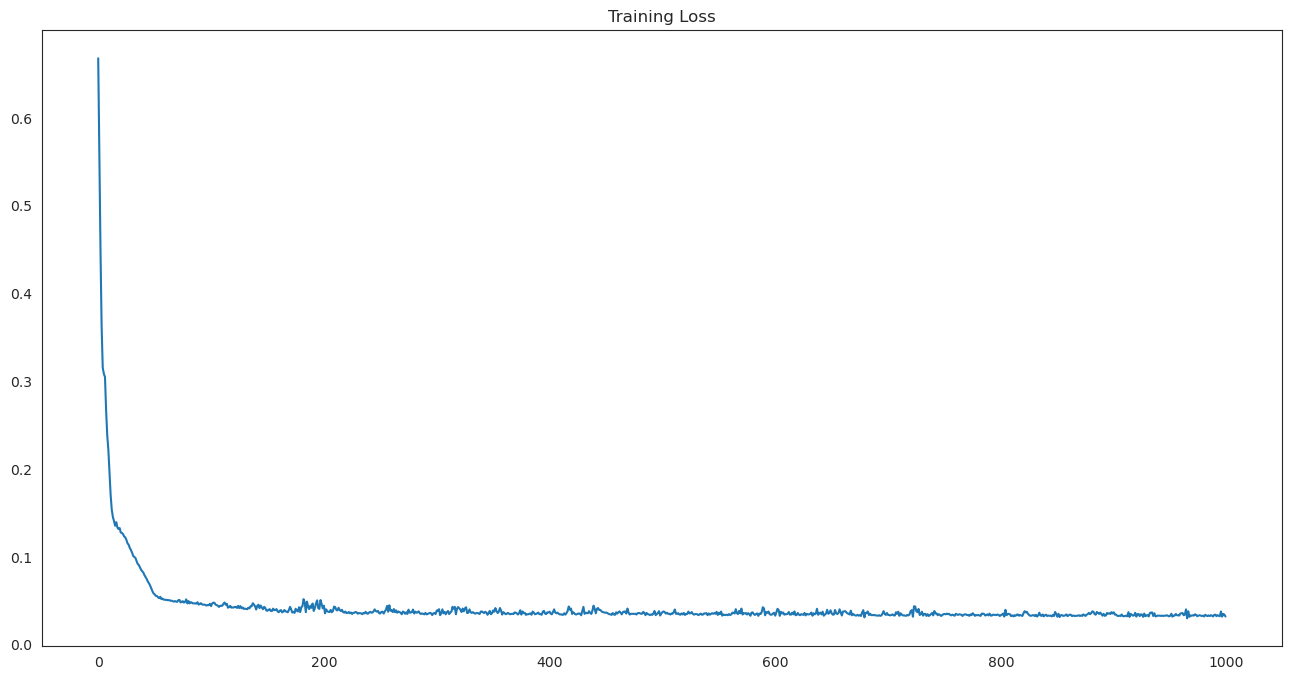

In [96]:
# Monitor the model's performances by monitoring the Training and Validation Loss
plt.figure(figsize=(16,8))
plt.title("Training Loss")
plt.plot(history.history["loss"])
plt.show()

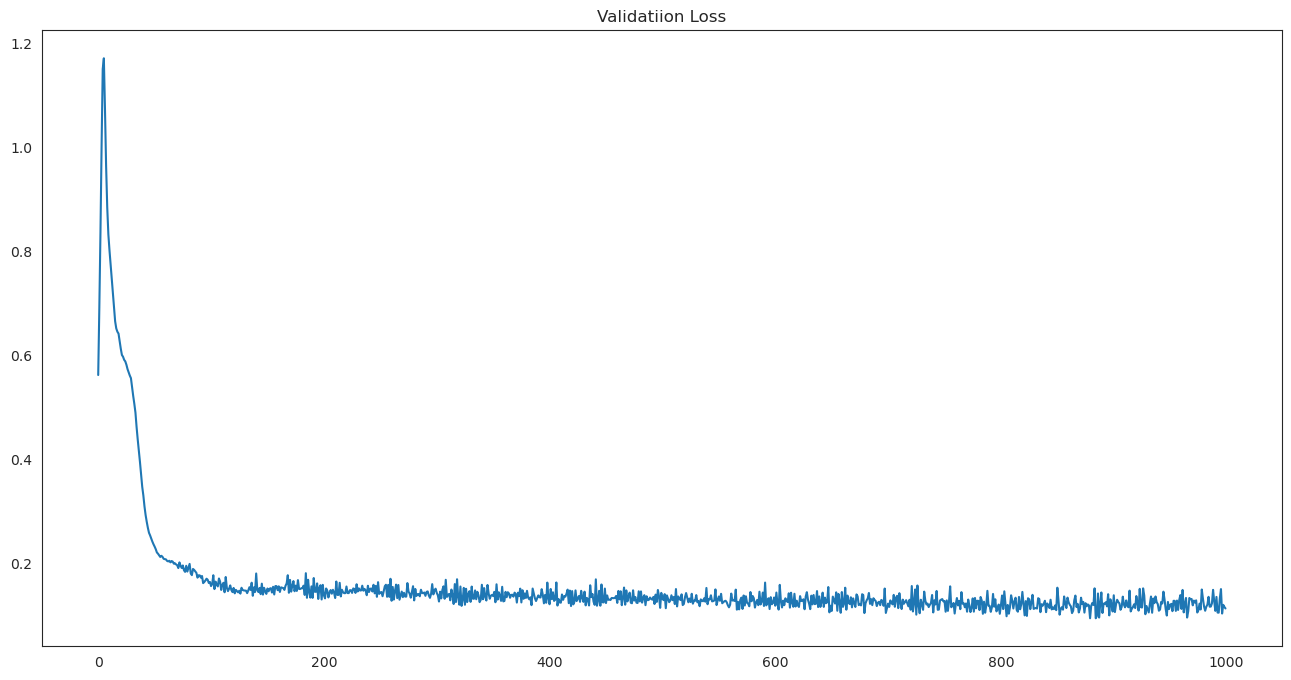

In [97]:
# Monitor the model's performances by monitoring the Training and Validation Loss
plt.figure(figsize=(16,8))
plt.title("Validatiion Loss")
plt.plot(history.history["val_loss"])
plt.show()

--------

# Closed Form Continuous Time Networks

[CfCs](https://www.nature.com/articles/s42256-022-00556-7) are an approximation of a [closed form solution](https://en.wikipedia.org/wiki/Closed-form_expression) that MIT's CSAIL found which yeilds superior performances over the 'vanilla' LTCs due to the lack of [numerical ODE solver](https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations) computations

<br>

The researchers at MIT's CSAIL introduced multiple variations of the CfC architecture, each more 'specialized' for different tasks such as the CfC-noGate or the CfC-mmRNN (mixed memory)

<br>

The good thing is that CfCs can be 'compiled' from LTCs which have been more extensively trained on large datasets, however this performance increase for both training and inference for CfCs isn't cost free, because CfCs do have slightly worse performances than vanilla LTCs.
However for many applications, such as Time Series Forecasting for which these models where born to be applied for, an appropriately configured LTC can be trained on a large dataset in order to truly grasp the dynamics of the underlying data, and then 'compiled' into a CfC model in order to have fast inference time (due to the aforementioned lack of ODE solver).

--------

In [98]:
from ncps.keras import CfC# Define a custom wiring on the CfC Model

# 8 Neurons in total, 1 of which is the output neuron
wiring = AutoNCP(10, 1)

model = Sequential()
model.add(InputLayer(input_shape = (None, n_features)))
model.add(CfC(wiring))

model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.01), metrics = [RootMeanSquaredError()])

/home/drew/miniconda3/envs/data-analytics/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [99]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cf_c (CfC)                      │ (None, 1)              │           332 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332 (1.30 KB)

 Trainable params: 332 (1.30 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
checkpoint_callback = ModelCheckpoint("models/ts_cfc.keras", save_best_only = True)

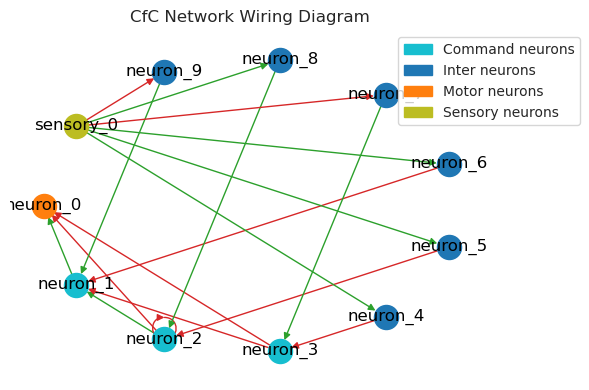

In [101]:
# Model's wirings
sns.set_style("white")
plt.figure(figsize=(6, 4))
plt.title("CfC Network Wiring Diagram")
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [102]:
# Fit on the training data
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 1000, callbacks = [checkpoint_callback], verbose = 0)

In [103]:
train_mse = history.history["loss"][-1]
print("Training MSE:\t{:.3f}".format(train_mse))

Training MSE:	0.013


In [104]:
train_preds = model.predict(X_train, verbose = 0)

In [105]:
train_predictions = pd.DataFrame(
    {
        "Train Predictions" : train_preds.flatten(),
        "Ground Trouth" : y_train.flatten()
    }
)
train_predictions

,Train Predictions,Ground Trouth
0,-1.158794,-1.265578
1,-1.219683,-1.332496
2,-1.255124,-1.215389
3,-1.122859,-1.106647
4,-1.054204,-1.106647
...,...,...
91,-0.181289,-0.077781
92,-0.007654,0.214986
93,0.346664,0.290269
94,0.246042,0.173162


[]

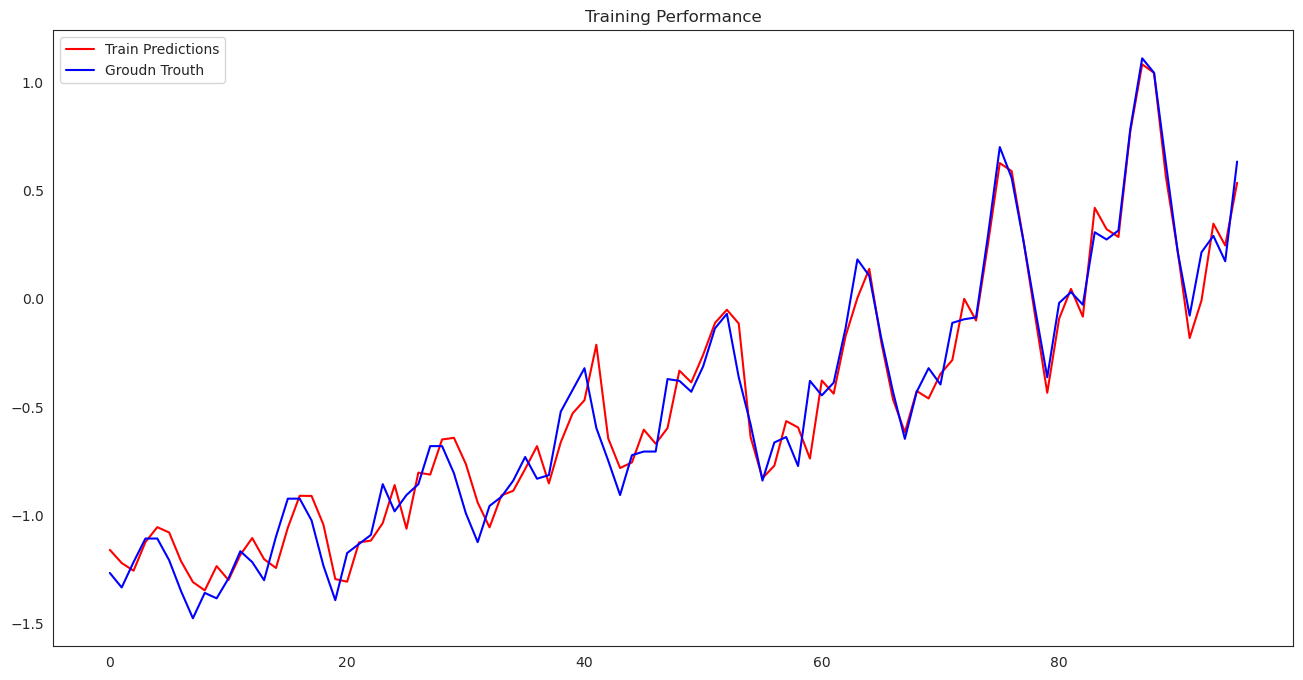

In [106]:
# Plot the Training performances
plt.figure(figsize=(16, 8))
plt.title("Training Performance")
plt.plot(train_predictions["Train Predictions"], color='r', label = "Train Predictions")
plt.plot(train_predictions["Ground Trouth"], color='b', label = "Groudn Trouth")
plt.legend()
plt.plot()

In [107]:
# Evaluate the model's Test Set Performances
test_preds = model.predict(X_test, verbose = 0)

In [108]:
test_predictions = pd.DataFrame(
    {
        "Test Predictions" : test_preds.flatten(),
        "Ground Trouth" : y_test.flatten()
    }
)
test_predictions

,Test Predictions,Ground Trouth
0,0.476827,0.658319
1,0.838909,0.248445
2,-0.233939,0.474294
3,0.515433,0.666684
4,0.729349,0.516118
5,0.487314,1.051463
6,1.669321,0.967815
7,0.149064,1.168570
8,1.312658,1.603538
9,0.691026,2.239260


In [109]:
y_test.flatten().shape

(26,)

In [110]:
mse = MeanSquaredError()
test_mse = mse(test_preds, y_test).numpy()
print("Test MSE:\t{:.3f}".format(test_mse))

Test MSE:	1.236


[]

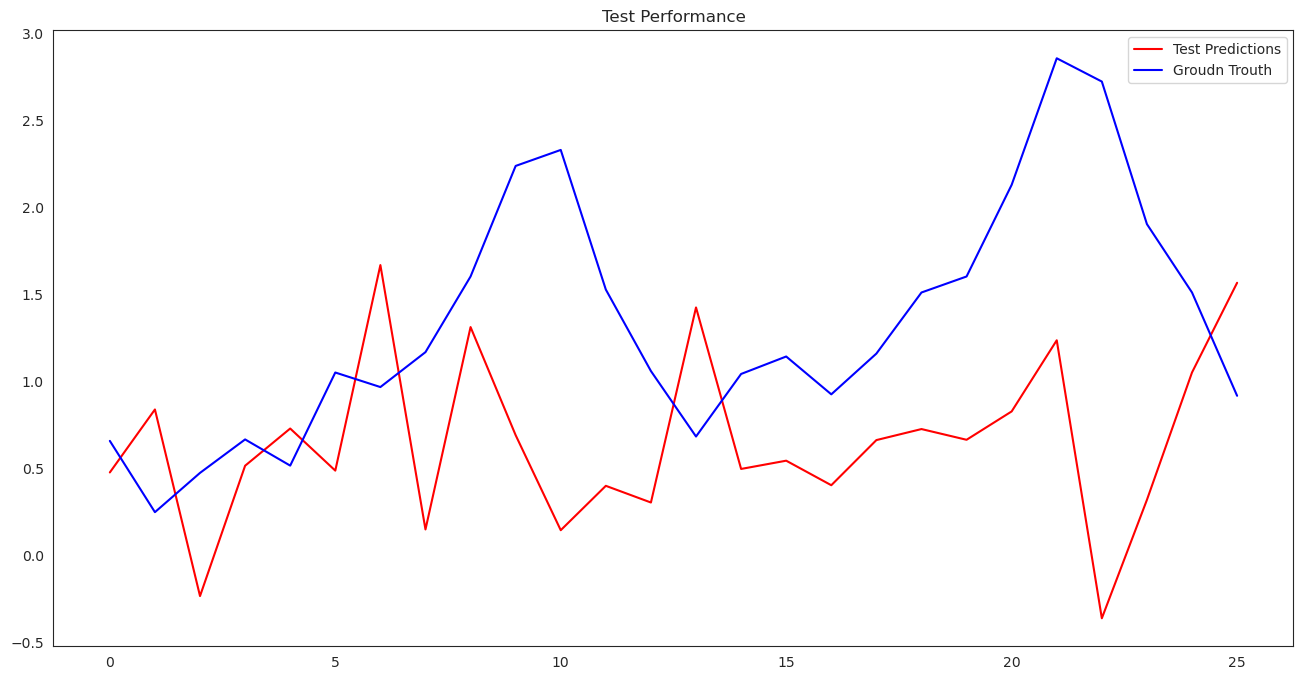

In [111]:
# Plot the test set's performances
plt.figure(figsize=(16, 8))
plt.title("Test Performance")
plt.plot(test_predictions["Test Predictions"], color='r', label = "Test Predictions")
plt.plot(test_predictions["Ground Trouth"], color='b', label = "Groudn Trouth")
plt.legend()
plt.plot()

In [112]:
results.append(["CfC", train_mse, test_mse, sqrt(train_mse), sqrt(test_mse)])

In [113]:
print("Model Train MSE:\t{:.3f}\t\t|\tModel Test MSE:\t{:.3f}".format(train_mse, test_mse))

Model Train MSE:	0.013		|	Model Test MSE:	1.236


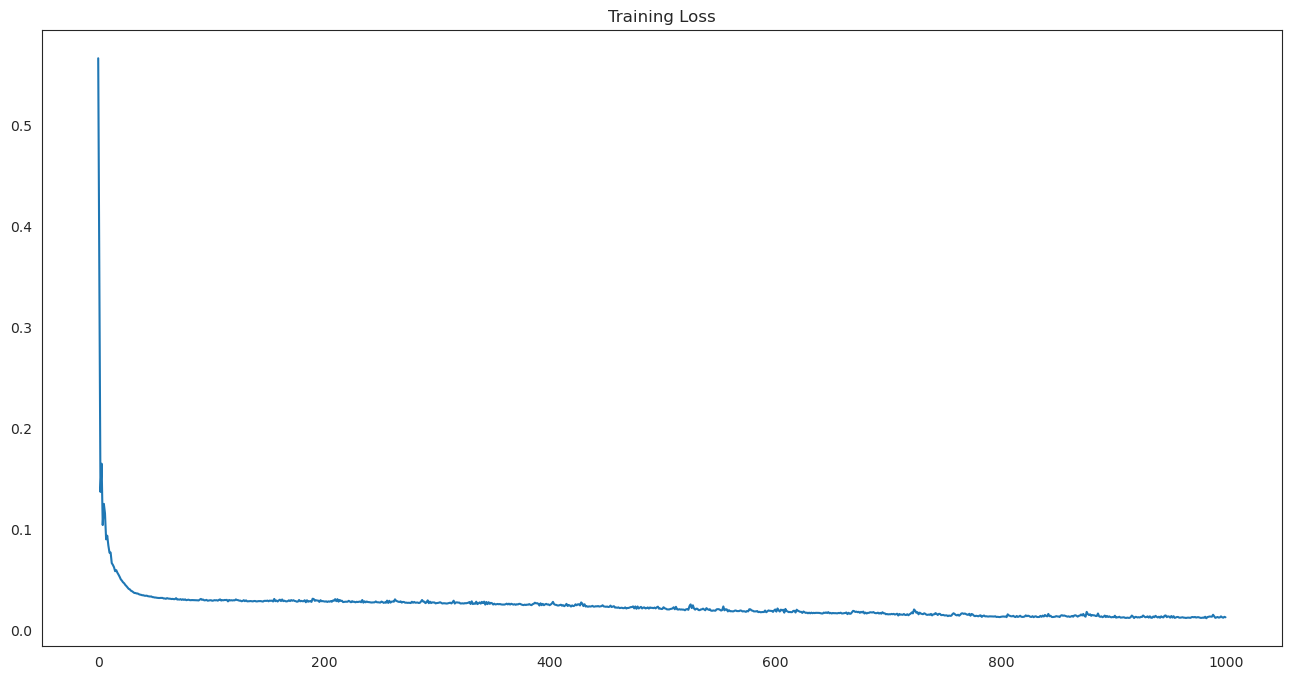

In [114]:
# Monitor the model's performances by monitoring the Training and Validation Loss
plt.figure(figsize=(16,8))
plt.title("Training Loss")
plt.plot(history.history["loss"])
plt.show()

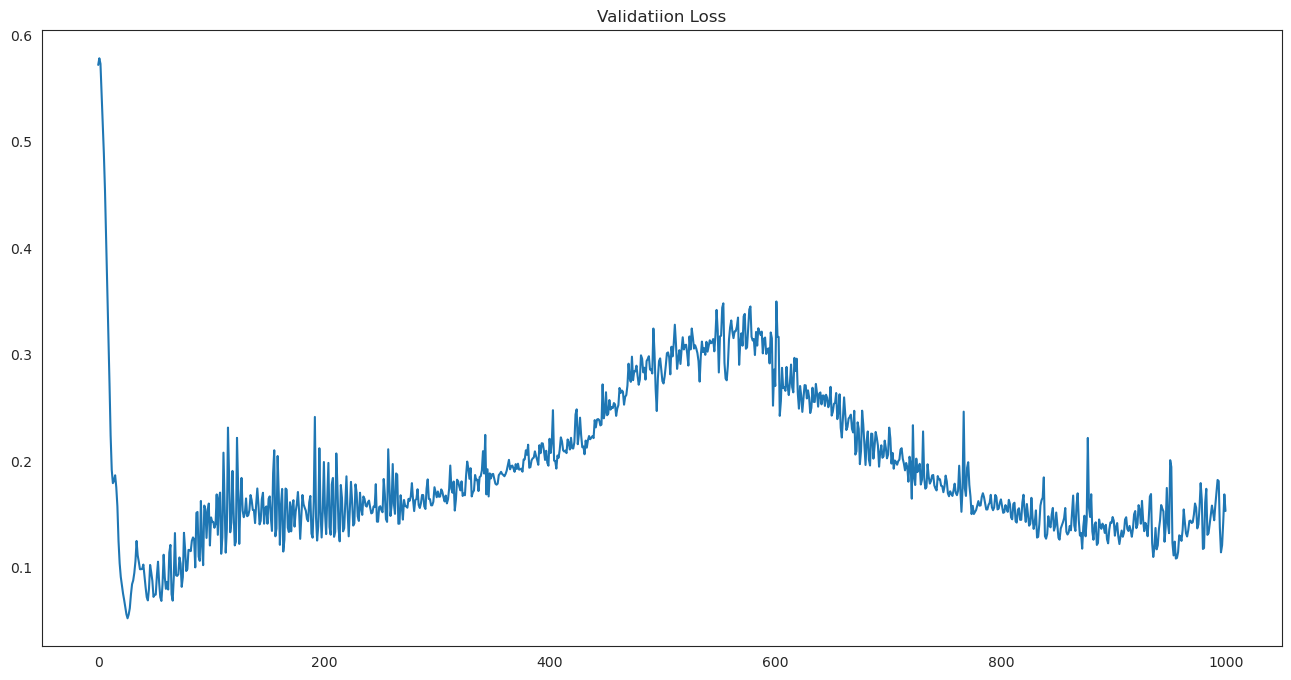

In [115]:
# Monitor the model's performances by monitoring the Training and Validation Loss
plt.figure(figsize=(16,8))
plt.title("Validatiion Loss")
plt.plot(history.history["val_loss"])
plt.show()

-------

### More on Liquid Models

Despite time series forecasting being the main interest of the LTC and CfC models, they might have much potential for other applications for 'main stream' deep learning, such as natural language processing and foundational models, as shown by the [Liquid AI](https://www.liquid.ai/), the company founded by MIT's researchers who worked on this technology.

<br>

Feel free to try out some [liquid foundation models](https://playground.liquid.ai/chat)

-------

# Conclusions

After conducting a thorough benchmarking of the various models and performing appropriate tuning for each one—an endeavor that was executed separately but based on the same dataset—the final DataFrame encompasses all the results. The findings indicate that the SARIMA model exhibits the greatest generalization power, whereas the CfC model demonstrates the poorest performance on the same dataset.

It is noteworthy, however, that among the deep learning models, transformers underperformed compared to LSTMs. Given the simplicity of the task and the limited time window, this outcome is not entirely unexpected.

In [116]:
# Convert the result list into a Pandas DataFrame
results = pd.DataFrame(
    results,
    columns = column_names
)

In [117]:
# If some entries have the -1 value it means that no value was collected for that particular experiment
results

,Model,Train MSE,Test MSE,Training RMSE,Test RMSE
0,ARIMA,-1.000000,0.070747,-1.000000,0.265984
1,SARIMA,-1.000000,0.027513,-1.000000,0.165871
2,LSTM,-1.000000,0.165762,-1.000000,0.407138
3,Transformer,0.025602,0.437559,0.160005,0.661483
4,LTC,0.032363,0.718390,0.179897,0.847579
5,CfC,0.013434,1.235866,0.115907,1.111695


In [119]:
# Sort the models based on RMSE
sorted_results = results.sort_values(by = "Test RMSE", ascending = True)
print(" ---- Models Ranked from best to worst ---- ")
sorted_results["Model"]

 ---- Models Ranked from best to worst ---- 


1         SARIMA
0          ARIMA
2           LSTM
3    Transformer
4            LTC
5            CfC
Name: Model, dtype: object

-------